In [1]:
import pandas as pd

# 读取Excel文件中的特定工作表
file_path = 'resources/bugs.xlsx'
sheet_name = '0709合并'  # 你可以更改为你想要读取的工作表名称
excel_data = pd.read_excel(file_path, sheet_name=sheet_name)
# 显示数据框的信息
print(excel_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 22 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   ID                                               250 non-null    int64  
 1   proj.                                            250 non-null    object 
 2   confid.                                          250 non-null    int64  
 3   actions                                          250 non-null    object 
 4   bic action type                                  250 non-null    object 
 5   测试                                               250 non-null    object 
 6   rootcause（给出 bug 根因的详细描述,尽可能提及 changes 代码，方便检索）  250 non-null    object 
 7   suitable error                                   250 non-null    object 
 8   self error                                       250 non-null    object 
 9   与修复关系                           

In [2]:
from data_checker import DataChecker
dataChecker = DataChecker()
action_count,bug_action_list = dataChecker.check_data(excel_data)
import matplotlib.pyplot as plt


# RQ1. What do bug-inducing commits do?
回归缺陷的的引入通常十分复杂，bic 里开发者究竟做了哪些事情，哪些操作导致了缺陷的引入？
为了回答这个问题，我们分析 bic 里包含了多少个具有原子性的[操作](https://www.conventionalcommits.org/en/v1.0.0/)。然后判断，哪个原子性的操作最终导致了 bug

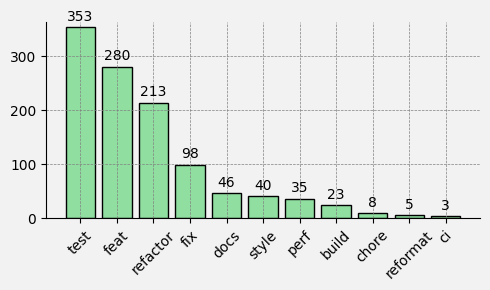

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置全局参数
mpl.rcParams.update({
    'font.size': 10,
    'figure.figsize': (5, 3),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.facecolor': (242/255, 242/255, 242/255),
    'figure.facecolor': (242/255, 242/255, 242/255),
    'axes.edgecolor': 'black',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
})
# 按值排序数据
action_count = dict(sorted(action_count.items(), key=lambda item: item[1], reverse=True))
# Extract labels and counts
labels = list(action_count.keys())
counts = list(action_count.values())

# Create the bar chart
fig, ax = plt.subplots()

# Using a specific color with black edges and a custom background color
bars = ax.bar(labels, counts, color=(145/255, 222/255, 161/255), edgecolor='black')

# Set background color
fig.patch.set_facecolor((242/255, 242/255, 242/255))
ax.set_facecolor((242/255, 242/255, 242/255))

# Adding labels and title
# ax.set_xlabel('Labels')
# ax.set_ylabel('Counts')
# ax.set_title('Development Activities in Bug-Inducing Commits')
ax.set_ylim(0, max(counts) + 10)

# Adding the count text on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('resources/bug_action_count.png', dpi=400)
# Show the plot
plt.show()

In [4]:
total_sum = sum(action_count.values())
total_sum

1104

In [7]:
bug_action_appear = {}
# 遍历每个item
for item in bug_action_list:
    # 遍历每个item中的每个key（action_name）
    for key in item.keys():
        if key in bug_action_appear:
            # 如果key已存在，增加其计数
            bug_action_appear[key] += 1
        else:
            # 如果key不存在，初始化计数为1
            bug_action_appear[key] = 1

# 打印结果，显示每个action_name出现的次数
print(bug_action_appear)

{'refactor': 90, 'fix': 83, 'test': 177, 'docs': 41, 'feat': 164, 'perf': 30, 'style': 21, 'build': 21, 'reformat': 5, 'ci': 3, 'chore': 6}


In [9]:

from collections import defaultdict
critical_bic_actions=defaultdict(int)
count = 0
for index,row in excel_data.iterrows(): 
    c_bic_ac = row['bic action type'].split(',')
    if len(c_bic_ac) > 1:
        for ac in c_bic_ac:
            if ac == 'enhance' or ac == 'enhancement ':
                ac = 'feat'
            if ac == 'Reimpl.':
                ac = 'refactor'
            critical_bic_actions[ac] += 1        
        count+=1
    else:
        if c_bic_ac[0] == 'enhance' or c_bic_ac[0] == 'enhancement ':
            c_bic_ac[0] = 'feat'
        if c_bic_ac[0] == 'Reimpl.':
            c_bic_ac[0] = 'refactor'    
        critical_bic_actions[c_bic_ac[0]] += 1
print(critical_bic_actions)
print("Total rows processed:", count)

defaultdict(<class 'int'>, {'refactor': 38, 'fix': 66, 'feat': 128, 'build': 1, 'perf': 24})
Total rows processed: 7


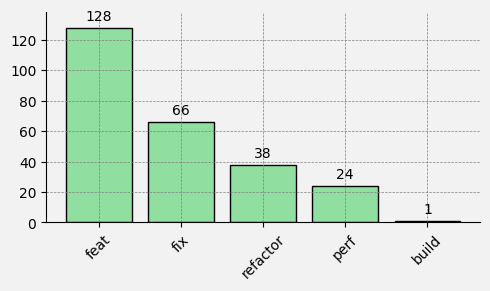

In [12]:
# 按值排序数据
critical_bic_actions = dict(sorted(critical_bic_actions.items(), key=lambda item: item[1], reverse=True))
# Extract labels and counts
labels = list(critical_bic_actions.keys())
counts = list(critical_bic_actions.values())

# Create the bar chart
fig, ax = plt.subplots()

# Using a specific color with black edges and a custom background color
bars = ax.bar(labels, counts, color=(145/255, 222/255, 161/255), edgecolor='black')

# Set background color
fig.patch.set_facecolor((242/255, 242/255, 242/255))
ax.set_facecolor((242/255, 242/255, 242/255))

# Adding labels and title
# ax.set_xlabel('Labels')
# ax.set_ylabel('Counts')
# ax.set_title('Development Activities in Bug-Inducing Commits')
ax.set_ylim(0, max(counts) + 10)

# Adding the count text on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('resources/critical_bic_actions.png', dpi=400)
# Show the plot
plt.show()

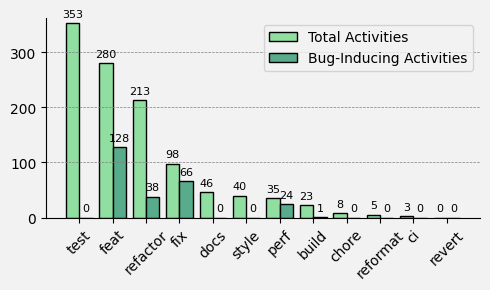

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 设置全局参数
mpl.rcParams.update({
    'font.size': 10,
    'figure.figsize': (5, 3),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.facecolor': (242/255, 242/255, 242/255),
    'figure.facecolor': (242/255, 242/255, 242/255),
    'axes.edgecolor': 'black',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
})
# 按值排序数据
action_count = dict(sorted(action_count.items(), key=lambda item: item[1], reverse=True))

# # 计算平均值并保留一位小数
# average_total = round(sum(action_count.values()) / 120, 2)
# average_bugs = round(sum(critical_bic_actions.get(key, 0) for key in action_count.keys()) / 120, 2)

# 计算平均值并保留一位小数
average_total = 0
average_bugs = 0
# 将字典转换为DataFrame
df_actions = pd.DataFrame({
    'Activity': list(action_count.keys()) + ['revert'],
    'Total': list(action_count.values()) + [average_total],
    'Bugs': [critical_bic_actions.get(key, 0) for key in action_count.keys()] + [average_bugs]
})

# 设置柱子的宽度
bar_width = 0.4

# 创建X轴位置的数组，使柱子错开
x = np.arange(len(df_actions['Activity']))
fig, ax = plt.subplots()

# 绘制总活动数的柱状图，稍微向左偏移
bars = ax.bar(x - bar_width/2, df_actions['Total'], width=bar_width, color=(145/255, 222/255, 161/255), edgecolor='black', label='Total Activities')

# 绘制引发bug的活动数的柱状图，稍微向右偏移
bars_bug = ax.bar(x + bar_width/2, df_actions['Bugs'], width=bar_width, color=(88/255, 172/255, 139/255), edgecolor='black', label='Bug-Inducing Activities')

# 设置背景颜色
fig.patch.set_facecolor((242/255, 242/255, 242/255))
ax.set_facecolor((242/255, 242/255, 242/255))

# 设置Y轴范围
ax.set_ylim(0, max(df_actions['Total']) + 10)
# 添加数值标签到总活动数的柱状图顶部
for i, (bar, total) in enumerate(zip(bars, df_actions['Total'])):
    height = bar.get_height()
    label = f'{int(height)}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 向上偏移3点
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# 添加数值标签到引发bug的活动数的柱状图顶部
for i, (bar, bugs) in enumerate(zip(bars_bug, df_actions['Bugs'])):
    height = bar.get_height()
    label = f'{int(height)}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 向上偏移3点
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)


# # 设置X轴标签和标题
# ax.set_xlabel('Activity')
# ax.set_ylabel('Count')
# ax.set_title('Software Development Activities: Total vs Bugs')

# 设置X轴的刻度和标签
ax.set_xticks(x)
ax.set_xticklabels(df_actions['Activity'], rotation=45)

# 添加图例
ax.legend()

# 设置网格线样式
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # 开启所有网格线
for line in ax.get_xgridlines():  # 获取所有竖线
    line.set_visible(False)  # 隐藏竖线

# 调整布局
plt.tight_layout()

# 保存和显示图表
plt.savefig('resources/bug_action_count_offset.png', dpi=400)
plt.show()

RQ2 

In [14]:
count_contains_test = 0
count_all_tests=0 
for row in bug_action_list:
    if 'test' in row:
        count_all_tests += row['test']
        count_contains_test += 1
print("Total rows processed:", count_all_tests)
print("Total rows with test:", count_contains_test/count_all_tests)            


Total rows processed: 353
Total rows with test: 0.5014164305949008


In [15]:
def is_chinese(character):
    if '\u4e00' <= character <= '\u9fff':
        return True
    return False
test_type_map = defaultdict(int)
for index,row in excel_data.iterrows():
    tests_diff_type = row['测试']
    if not is_chinese(tests_diff_type):
        continue
    test_types = tests_diff_type.split(',')
    for test_type in test_types:
        test_type_map[test_type] += 1
print(test_type_map)        

defaultdict(<class 'int'>, {'缺失数据': 91, '缺失特征': 84, '规约不一致': 22, '过时': 9, '缺失配置': 1})


In [16]:
miss_test_type_map = defaultdict(int)
for index,row in excel_data.iterrows():
    tests_diff_type = row['测试']
    if is_chinese(tests_diff_type):
        continue
    test_types = tests_diff_type.split(',')
    for test_type in test_types:
        miss_test_type_map[test_type] += 1
print(miss_test_type_map)     

defaultdict(<class 'int'>, {'miss': 37, 'miss data': 5, 'exist': 3})


In [17]:
first_120_rows = excel_data


In [18]:
# 获取 'suitable error' 和 'self error' 都不为 'No' 的数据行索引
filtered_indices = first_120_rows[
    (first_120_rows['suitable error'] == 'No') & (first_120_rows['self error'] == 'No')
].index

# 将索引转换为列表
filtered_indices_list = filtered_indices.tolist()

filtered_indices_list

[]

In [19]:
import pandas as pd
from collections import defaultdict

# Assuming first_120_rows is your DataFrame
grouped_data = first_120_rows.groupby(['suitable error', 'self error'])

names = []
bug_counts = []
feat_counts = []
knowledge_maps = []
with_fix_maps = []

# Display the grouped data
for name, group in grouped_data:
    with_fix_map = defaultdict(int)
    feat_count = 0
    knowledge_map = defaultdict(int)

    for index, row in group.iterrows():
        with_fix_map[row['与修复关系']] += 1
        
        if row['feat.'] == 1:
            feat_count += 1
        
        knowledge = row['知识']
        if '项目知识' in knowledge and '领域知识' not in knowledge:
            knowledge_map['项目知识'] += 1
        elif '项目知识' not in knowledge and '领域知识' in knowledge:
            knowledge_map['领域知识'] += 1
        elif '项目知识' in knowledge and '领域知识' in knowledge:
            knowledge_map['项目+领域'] += 1
        else:
            knowledge_map['编程知识'] += 1
    name_str = name[1] if name[0] == 'No' else name[0]
    # print(f"name:{name_str},#bug:{len(group)},#Feat: {feat_count},Knowledge: {knowledge_map}, With Fix: {with_fix_map}")
    # Store data in lists
    names.append(name_str)
    bug_counts.append(len(group))
    feat_counts.append(feat_count)
    knowledge_maps.append(knowledge_map)
    with_fix_maps.append(with_fix_map)
# Convert lists to DataFrame
result_df = pd.DataFrame({
    'Name': names,
    '#Bug': bug_counts,
    '#Feat': feat_counts,
    'Knowledge': knowledge_maps,
    'With Fix': with_fix_maps
})

# Explode the dictionaries into separate columns
knowledge_df = result_df['Knowledge'].apply(pd.Series).fillna(0).astype(int)
with_fix_df = result_df['With Fix'].apply(pd.Series).fillna(0).astype(int)

# Combine all data into one DataFrame
final_df = pd.concat([result_df[['Name', '#Bug', '#Feat']], knowledge_df, with_fix_df], axis=1)

# Export the DataFrame to an Excel file
output_file_path = 'grouped_data_with_knowledge_and_with_fix.xlsx'
final_df.to_excel(output_file_path, index=False)    

In [20]:
df = pd.read_excel(output_file_path)

# Merge 'extends,call' and 'call' entries
df.loc[df['Name'] == 'extends,call', 'Name'] = 'call'

# Group by 'Name' and aggregate the data
grouped = df.groupby('Name').agg({
    '#Bug': 'sum',
    '#Feat': 'sum',
    '项目知识': 'sum',
    '项目+领域': 'sum',
    '领域知识': 'sum',
    '编程知识': 'sum',
    'same location': 'sum',
    'same method': 'sum',
    'same class': 'sum',
    'other': 'sum',
    'same package': 'sum'
}).reset_index()

# Define the final structure based on the screenshot
final_structure = {
    'Rootcause': grouped['Name'],
    '#Bugs': grouped['#Bug'],
    '#Feat': grouped['#Feat'],
    'Knowledge': {
        'Programming': grouped['编程知识'],
        'Domain': grouped['领域知识'],
        'Project': grouped['项目知识'],
        'Domain & Project': grouped['项目+领域']
    },
    'With Fix': {
        'same location': grouped['same location'],
        'same method': grouped['same method'],
        'same class': grouped['same class'],
        'other': grouped['other'],
        'same package': grouped['same package']
    }
}

# Create a new DataFrame with the final structure
final_df = pd.DataFrame({
    'Rootcause': final_structure['Rootcause'],
    '#Bugs': final_structure['#Bugs'],
    '#Feat': final_structure['#Feat'],
    'Programming': final_structure['Knowledge']['Programming'],
    'Domain': final_structure['Knowledge']['Domain'],
    'Project': final_structure['Knowledge']['Project'],
    'Domain & Project': final_structure['Knowledge']['Domain & Project'],
    'same location': final_structure['With Fix']['same location'],
    'same method': final_structure['With Fix']['same method'],
    'same class': final_structure['With Fix']['same class'],
    'other': final_structure['With Fix']['other'],
    'same package': final_structure['With Fix']['same package']
})

# Save the final DataFrame to an Excel file
output_file_path_final = 'final_grouped_data.xlsx'
final_df.to_excel(output_file_path_final, index=False)

In [ ]:
# 计算“与修复关系”列中每个标签的数量
relationship_counts = data['与修复关系'].value_counts()

relationship_proportions = relationship_counts / relationship_counts.sum() * 100

# 将数量和比例合并为一个数据框以便显示
relationship_data = pd.DataFrame({
    'Count': relationship_counts,
    'Proportion (%)': relationship_proportions
})

# 生成带有数量和比例的柱状图
plt.figure(figsize=(12, 8))
bars = plt.bar(relationship_data.index, relationship_data['Count'], color='skyblue')
plt.title('Counts and Proportions of Each Label')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 在柱状图上标注比例值
for bar, proportion in zip(bars, relationship_data['Proportion (%)']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{proportion:.1f}%', va='bottom', ha='center')

# 显示图表
plt.show()

# 显示数量和比例的数据框
print(relationship_data)

In [ ]:
import pandas as pd
from collections import defaultdict
# 确保 'bic action type' 被视为字符串

# 加载数据
file_path = 'resources/anna_dta.csv'
data = pd.read_csv(file_path)

data['bic action type'] = data['bic action type'].astype(str)

# 初始化一个字典来存储计数
action_relationship_counts = defaultdict(lambda: defaultdict(int))

# 逐行遍历数据框
for _, row in data.iterrows():
    actions = row['bic action type'].split(',')
    relationship = row['与修复关系']
    
    for action in actions:
        action = action.strip()  # 去除任何前导/尾随空白
        action_relationship_counts[action][relationship] += 1

# 将字典转换为数据框以便更好地显示
action_relationship_df = pd.DataFrame(action_relationship_counts).fillna(0).astype(int).T

# 打印结果
print(action_relationship_df)


# 保存结果到文件
action_relationship_df.to_csv('action_relationship_counts.csv')